In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
import scipy
import seaborn as sns


df_raw = pd.read_csv("mtbs_tropical_annotations.tsv", sep = "\t")
df_raw.head()

,feature_id,component_id,libname,structure_inchikey,structure_smiles,structure_molecular_formula,structure_taxonomy_npclassifier_01pathway,structure_taxonomy_npclassifier_02superclass,structure_taxonomy_npclassifier_03class
0,64000,2173,MS1_match,SRBFZHDQGSBBOR-HWQSCIPKSA-N,OC1OC[C@H](O)[C@H](O)[C@H]1O,C5H10O5,Carbohydrates,Saccharides,Monosaccharides
1,64000,2173,MS1_match,PYMYPHUHKUWMLA-WDCZJNDASA-N,O=C[C@@H](O)[C@H](O)[C@H](O)CO,C5H10O5,Carbohydrates,Saccharides,Monosaccharides
2,63994,2138,MS1_match,GLDOVTGHNKAZLK-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCCO,C18H38O,Fatty acids,Fatty acyls,Fatty alcohols
3,63993,47,ISDB,FZFFGBOPCQADGY-UHFFFAOYSA-N,CC(C)=CCCC(C)=CCC1(CC=C(C)C)C(=O)C(O)=Cc2oc3cc...,C28H32O6,Shikimates and Phenylpropanoids,Xanthones,Plant xanthones
4,63991,664,MS1_match,KFXIUXCXSKTCNK-KLGAAMDDSA-N,C=C1C2=Nc3ccccc3[C@@]23CCN2C/C(=C/C)[C@H]1C[C@...,C19H20N2,Terpenoids,Diterpenoids,Valparane diterpenoids


In [3]:
## cleanup
df_clean = df_raw.drop_duplicates(subset="structure_smiles").dropna()
df_clean.describe()

,feature_id,component_id
count,22809.000000,22809.000000
mean,35321.158139,2972.267877
std,18346.377352,3128.711565
min,17.000000,-1.000000
25%,20443.000000,555.000000
50%,37316.000000,1732.000000
75%,50865.000000,4416.000000
max,64000.000000,14487.000000


In [9]:
df_clean["structure_taxonomy_npclassifier_03class"].value_counts()

df_clean = df_clean[df_clean["structure_taxonomy_npclassifier_03class"].isin(["Germacrane sesquiterpenoids","Limonoids","Oleanane triterpenoids","Colensane and Clerodane diterpenoids","Guaiane sesquiterpenoids"])]

df_clean.describe()

df_clean.nunique()

feature_id                                      1936
component_id                                     843
libname                                            2
structure_inchikey                              4418
structure_smiles                                4418
structure_molecular_formula                     1067
structure_taxonomy_npclassifier_01pathway          1
structure_taxonomy_npclassifier_02superclass       3
structure_taxonomy_npclassifier_03class            5
MolWt                                           1719
NumHeteroatoms                                    40
HeavyAtomCount                                    92
NumAromaticRings                                   3
NumAromaticHeterocycles                            3
NumHAcceptors                                     40
NumSaturatedRings                                 13
dtype: int64

In [8]:

df_clean["MolWt"] = df_clean["structure_smiles"].apply(lambda s: Descriptors.MolWt(Chem.MolFromSmiles(s)))
df_clean["NumHeteroatoms"] = df_clean["structure_smiles"].apply(lambda s: Descriptors.NumHeteroatoms(Chem.MolFromSmiles(s)))
df_clean["HeavyAtomCount"] = df_clean["structure_smiles"].apply(lambda s: Descriptors.HeavyAtomCount(Chem.MolFromSmiles(s)))
df_clean["NumAromaticRings"] = df_clean["structure_smiles"].apply(lambda s: Descriptors.NumAromaticRings(Chem.MolFromSmiles(s)))
df_clean["NumAromaticHeterocycles"] = df_clean["structure_smiles"].apply(lambda s: Descriptors.NumAromaticHeterocycles(Chem.MolFromSmiles(s)))
df_clean["NumHAcceptors"] = df_clean["structure_smiles"].apply(lambda s: Descriptors.NumHAcceptors(Chem.MolFromSmiles(s)))
df_clean["NumSaturatedRings"] = df_clean["structure_smiles"].apply(lambda s: Descriptors.NumSaturatedRings(Chem.MolFromSmiles(s)))

df_clean.head()

df_predictors = df_clean[["MolWt", "NumHeteroatoms", "HeavyAtomCount", "NumAromaticRings", "NumAromaticHeterocycles", "NumHAcceptors", "NumSaturatedRings",'structure_taxonomy_npclassifier_03class']]



In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint
from sklearn.inspection import permutation_importance

X_train, X_test, y_train, y_test = train_test_split(
    df_predictors[["MolWt", "NumHeteroatoms", "HeavyAtomCount", "NumAromaticRings", "NumAromaticHeterocycles", "NumHAcceptors", "NumSaturatedRings"]],
    df_predictors[['structure_taxonomy_npclassifier_03class']],
    test_size=0.2, random_state=42
    )

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
# X_train_norm = preprocessing.normalize(X_train)
# X_test_norm = preprocessing.normalize(X_test)

class_predictor = RandomForestClassifier(min_samples_split=5, min_samples_leaf=2, random_state=42)
rand_search = RandomizedSearchCV(class_predictor, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5, random_state=42)
rand_search.fit(X_train, y_train)



c:\Users\UZH\Unsynced_UZH\projects\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\UZH\Unsynced_UZH\projects\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\UZH\Unsynced_UZH\projects\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\UZH\Unsynced_UZH\projects\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array

,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....001EC008E0A50>, 'n_estimators': <scipy.stats....001EC0082B380>}"
,n_iter,5
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


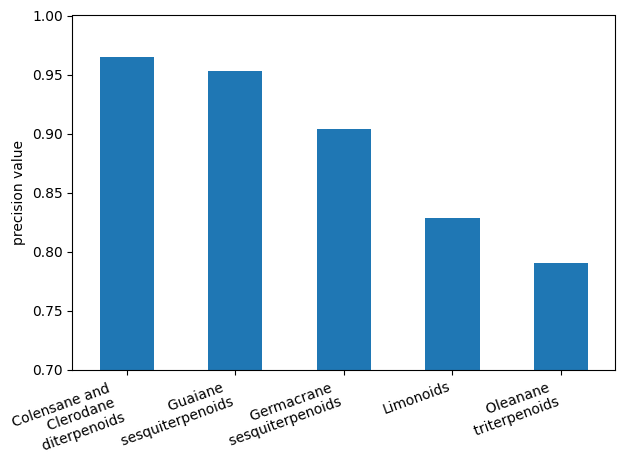

In [11]:
from sklearn.metrics import accuracy_score, precision_score
best_rf = rand_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = None)

classes = [
    "Germacrane \n sesquiterpenoids",
    "Limonoids",
    "Oleanane \n triterpenoids",
    "Colensane and \n Clerodane \n diterpenoids",
    "Guaiane \n sesquiterpenoids"]

pred_accuracies = pd.Series(precision, index = classes)
pred_accuracies = pred_accuracies.sort_values(ascending = False)
fig, ax = plt.subplots()
ax.set_ylim([0.7,1])
pred_accuracies.plot.bar(ax=ax)
plt.xticks(rotation=20, ha="right")
# ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("precision value")
fig.tight_layout()
plt.show()


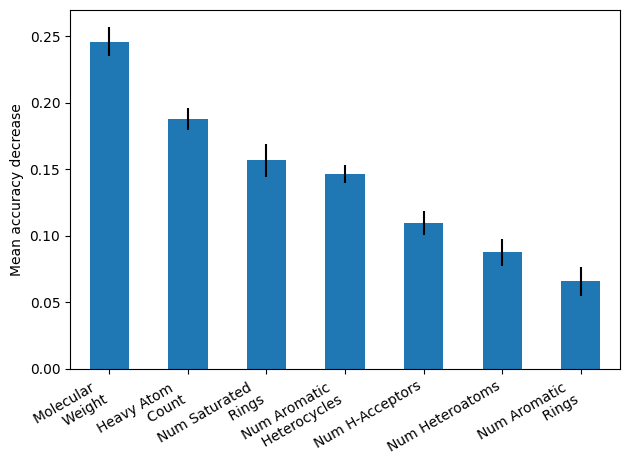

In [12]:
importances = best_rf.feature_importances_

result = permutation_importance(
    best_rf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)
forest_importances = pd.Series(importances, index=["Molecular \n Weight", "Num Heteroatoms", "Heavy Atom \n Count", "Num Aromatic \n Rings", "Num Aromatic \n Heterocycles", "Num H-Acceptors", "Num Saturated \n Rings"])
forest_importances = forest_importances.sort_values(ascending = False)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

# ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
plt.xticks(rotation=30, ha="right")
fig.tight_layout()
plt.show()



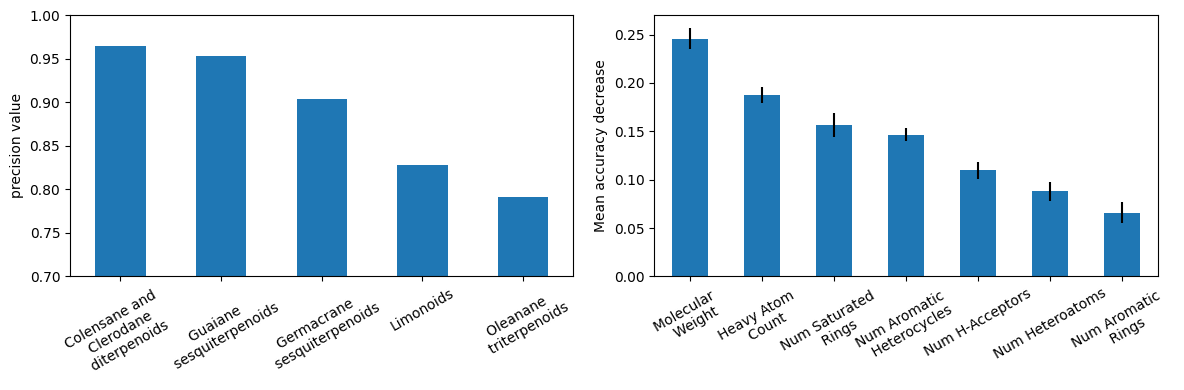

In [13]:
fig, [ax0,ax1] = plt.subplots(1,2, figsize = [12,4])

ax0.set_ylim([0.7,1])
pred_accuracies.plot.bar(ax=ax0)
# ax.set_title("Feature importances using permutation on full model")
ax0.set_ylabel("precision value")
ax0.tick_params("x", rotation=30)


forest_importances.plot.bar(yerr=result.importances_std, ax=ax1)
# ax.set_title("Feature importances using permutation on full model")
ax1.set_ylabel("Mean accuracy decrease")
ax1.tick_params("x", rotation=30)
fig.tight_layout()
plt.savefig("precision_accuracy_decrease.png", bbox_inches = "tight")